In [1]:
from __future__ import absolute_import
import os
import sys
sys.path.append('../')

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
from helpers import plots
from numpy import save

In [2]:
train_directory = '../data/MICCAI_BraTS_2019_Data_Training/'

In [3]:
def read_img(path):
    image = sitk.ReadImage(path, sitk.sitkUInt16)
    return sitk.GetArrayFromImage(image)

def normalize(s, image):
    return s / image.max()

In [6]:
sample_dir = 'BraTS19_TCIA09_255_1'
sample_path = train_directory + 'LGG/' + sample_dir + '/' + sample_dir
t2_img = read_img(sample_path + '_t2.nii.gz')
t1ce_img = read_img(sample_path + '_t1ce.nii.gz')
flair_img = read_img(sample_path + '_flair.nii.gz')
seg_img = read_img(sample_path + '_seg.nii.gz')
# test if shape of images is same
seg_img.shape == t2_img.shape == t1ce_img.shape == flair_img.shape

True

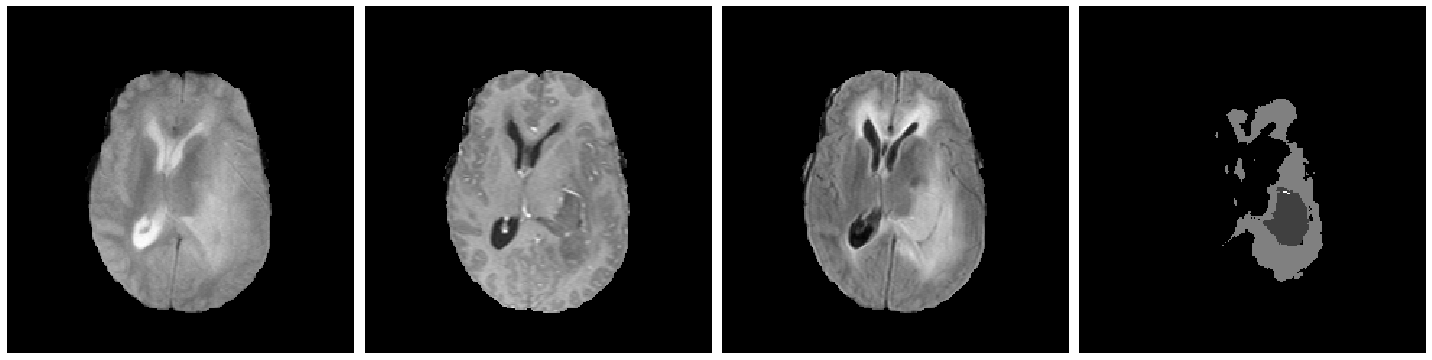

In [7]:
t2_slice = t2_img[80]
t1ce_slice = t1ce_img[80]
flair_slice = flair_img[80]
seg_slice = seg_img[80]

plots.plot_gray_images(np.array([t2_slice, t1ce_slice, flair_slice, seg_slice]), 4)

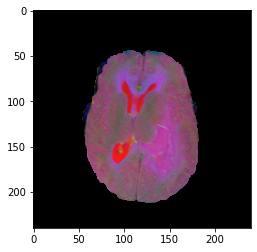

In [8]:
img = sitk.GetImageFromArray(np.array([t2_slice, t1ce_slice, flair_slice]), isVector=False)
vol = np.dstack(np.array([normalize(t2_slice, t2_img), 
                          normalize(t1ce_slice, t1ce_img), 
                          normalize(flair_slice,flair_img)]))
plt.imshow(vol)

In [9]:
def process_data(directory, postfixes, saving_directory, seg_directory=None, 
                 interval = (0, 1), slices_gap=1, num_of_samples=20):
    file_names = os.listdir(directory)
    random.seed(5)
    random.shuffle(file_names)
    file_names = file_names[int(len(file_names) * interval[0]): int(len(file_names) * interval[1])]
    iterator = 0
    for name in file_names:
#       read images
        images = [sitk.ReadImage(os.path.join(directory , name, name + postfix), sitk.sitkFloat32)
                for postfix in postfixes
                ]
        image_seg = sitk.ReadImage(os.path.join(directory , name, name +'_seg.nii.gz'))
#       transform image to n-dim numpy arrays
        vols = [sitk.GetArrayFromImage(image) for image in images]
        vol_seg = sitk.GetArrayFromImage(image_seg)
#       get slices with labels from image
        imgs_slices = [slice_images(vol, vol_seg, 50, 130, slices_gap) for vol in vols]
        slices_seg = slice_images(vol_seg, vol_seg, 50, 130, slices_gap)
#       get slice index with biggest tumor segmentation
        index = index_of_largest_segmentation(slices_seg)
        low_index = max(0, index - num_of_samples // 2)
        high_index = min(len(slices_seg), index + num_of_samples // 2 + 1)
        imgs_slices = [vol[low_index:high_index] for vol in imgs_slices]
        slices_seg = slices_seg[low_index:high_index]
#       save images
        for idx, (images, segmentation) in enumerate(zip(zip(*imgs_slices), slices_seg)):
            if segmentation[1] == 0:
                continue
            iterator += 1
            only_images = [img for (img, label) in images]
            normalized_images = [normalize(s, vol) for s, vol in zip(only_images,vols)] 
            
            image_name = name + '_' + str(idx) + '.png'
            save_image_rgb(normalized_images, os.path.join(saving_directory, image_name))
            if seg_directory:
                save_image_gray(segmentation[0],os.path.join(seg_directory, image_name))
            print(os.path.join(saving_directory, image_name))
        print(iterator, ' generated images')
        
        
def process_data_as_numpy(directory, postfixes, interval = (0, 1), slices_gap=1, num_of_samples=20,):
    file_names = os.listdir(directory)
    random.seed(5)
    random.shuffle(file_names)
    file_names = file_names[int(len(file_names) * interval[0]): int(len(file_names) * interval[1])]
    iterator = 0
    X = None
    X_seg = None
    
    for name in file_names:
#       read images
        images = [sitk.ReadImage(os.path.join(directory , name, name + postfix), sitk.sitkFloat32)
                for postfix in postfixes
                ]
        image_seg = sitk.ReadImage(os.path.join(directory , name, name +'_seg.nii.gz'))
#       transform image to n-dim numpy arrays
        vols = [sitk.GetArrayFromImage(image) for image in images]
        vol_seg = sitk.GetArrayFromImage(image_seg)
#       get slices with labels from image
        imgs_slices = [slice_images(vol, vol_seg, 50, 130, slices_gap) for vol in vols]
        slices_seg = slice_images(vol_seg, vol_seg, 50, 130, slices_gap)
#       get slice index with biggest tumor segmentation
        index = index_of_largest_segmentation(slices_seg)
        low_index = max(0, index - num_of_samples // 2)
        high_index = min(len(slices_seg), index + num_of_samples // 2 + 1)
        imgs_slices = [vol[low_index:high_index] for vol in imgs_slices]
        slices_seg = slices_seg[low_index:high_index]
#       save images
        for idx, (images, segmentation) in enumerate(zip(zip(*imgs_slices), slices_seg)):
            if segmentation[1] == 0:
                continue
            iterator += 1
            only_images = [img for (img, label) in images]
            normalized_images = [standardize(s, vol) for s, vol in zip(only_images,vols)] 
            if X is None:
                X = np.array([np.dstack(normalized_images)])
                X_seg = np.array([segmentation[0]])
            else:
                X = np.append([np.dstack(normalized_images)], X, axis=0)
                X_seg = np.append([segmentation[0]], X_seg, axis=0)
            
        print(iterator, ' generated images')
    return X, X_seg
        
def slice_images(image_vol, image_seg_vol, from_z, to_z, step):
    return [(image_vol[z], get_label(image_seg_vol[z])) for z in range(from_z, to_z, step)]

def normalize(s, image):
    return s / image.max() * 255   

def standardize(s, image):
    
    if np.isnan(image).any():
        print(file_names)
    if np.isnan(image[image > 0]).any():
        print(file_names)
    
    return (s - image[image > 0].mean()) / image[image > 0].std() 
        
def get_label(vol):
    return 1 if any(vol.flatten() > 0) else 0

def save_image_rgb(image, filename):
    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory) 
    vol = np.dstack(image)
    vol = vol.astype('uint8')
    im = Image.fromarray(vol)
    im.save(filename)
                            
def save_image_gray(image, filename):
    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory) 
    vol = image.astype('uint8')
    im = Image.fromarray(vol)
    im.save(filename)   
    
    
def index_of_largest_segmentation(segmentations):
    return np.argmax([np.sum(x.flatten() > 0) for x, y in segmentations])
    
    

In [10]:
process_data(train_directory + 'HGG', 
             ['_t2.nii.gz','_t1ce.nii.gz','_flair.nii.gz'], 
             '../data/train/confidence_19/HGG',
             '../data/train/seg_confidence_19/HGG',
             (0, 0.7),3,5)

../data/train/confidence_19/HGG/BraTS19_CBICA_AQO_1_0.png
../data/train/confidence_19/HGG/BraTS19_CBICA_AQO_1_1.png
../data/train/confidence_19/HGG/BraTS19_CBICA_AQO_1_2.png
../data/train/confidence_19/HGG/BraTS19_CBICA_AQO_1_3.png
../data/train/confidence_19/HGG/BraTS19_CBICA_AQO_1_4.png
5  generated images
../data/train/confidence_19/HGG/BraTS19_2013_3_1_0.png
../data/train/confidence_19/HGG/BraTS19_2013_3_1_1.png
../data/train/confidence_19/HGG/BraTS19_2013_3_1_2.png
../data/train/confidence_19/HGG/BraTS19_2013_3_1_3.png
../data/train/confidence_19/HGG/BraTS19_2013_3_1_4.png
10  generated images
../data/train/confidence_19/HGG/BraTS19_TCIA03_296_1_0.png
../data/train/confidence_19/HGG/BraTS19_TCIA03_296_1_1.png
../data/train/confidence_19/HGG/BraTS19_TCIA03_296_1_2.png
../data/train/confidence_19/HGG/BraTS19_TCIA03_296_1_3.png
../data/train/confidence_19/HGG/BraTS19_TCIA03_296_1_4.png
15  generated images
../data/train/confidence_19/HGG/BraTS19_CBICA_ALN_1_0.png
../data/train/confid

../data/train/confidence_19/HGG/BraTS19_CBICA_ASY_1_0.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ASY_1_1.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ASY_1_2.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ASY_1_3.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ASY_1_4.png
139  generated images
../data/train/confidence_19/HGG/BraTS19_TCIA03_474_1_0.png
../data/train/confidence_19/HGG/BraTS19_TCIA03_474_1_1.png
../data/train/confidence_19/HGG/BraTS19_TCIA03_474_1_2.png
../data/train/confidence_19/HGG/BraTS19_TCIA03_474_1_3.png
../data/train/confidence_19/HGG/BraTS19_TCIA03_474_1_4.png
144  generated images
../data/train/confidence_19/HGG/BraTS19_CBICA_AOC_1_0.png
../data/train/confidence_19/HGG/BraTS19_CBICA_AOC_1_1.png
../data/train/confidence_19/HGG/BraTS19_CBICA_AOC_1_2.png
../data/train/confidence_19/HGG/BraTS19_CBICA_AOC_1_3.png
../data/train/confidence_19/HGG/BraTS19_CBICA_AOC_1_4.png
149  generated images
../data/train/confidence_19/HGG/BraTS19_TMC_27374_1_0.png
.

../data/train/confidence_19/HGG/BraTS19_TCIA02_135_1_0.png
../data/train/confidence_19/HGG/BraTS19_TCIA02_135_1_1.png
../data/train/confidence_19/HGG/BraTS19_TCIA02_135_1_2.png
../data/train/confidence_19/HGG/BraTS19_TCIA02_135_1_3.png
../data/train/confidence_19/HGG/BraTS19_TCIA02_135_1_4.png
274  generated images
../data/train/confidence_19/HGG/BraTS19_TCIA06_211_1_0.png
../data/train/confidence_19/HGG/BraTS19_TCIA06_211_1_1.png
../data/train/confidence_19/HGG/BraTS19_TCIA06_211_1_2.png
../data/train/confidence_19/HGG/BraTS19_TCIA06_211_1_3.png
../data/train/confidence_19/HGG/BraTS19_TCIA06_211_1_4.png
279  generated images
../data/train/confidence_19/HGG/BraTS19_CBICA_ATP_1_0.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ATP_1_1.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ATP_1_2.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ATP_1_3.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ATP_1_4.png
284  generated images
../data/train/confidence_19/HGG/BraTS19_CBICA_ASR_1_0.

../data/train/confidence_19/HGG/BraTS19_CBICA_ATV_1_0.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ATV_1_1.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ATV_1_2.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ATV_1_3.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ATV_1_4.png
409  generated images
../data/train/confidence_19/HGG/BraTS19_CBICA_APZ_1_0.png
../data/train/confidence_19/HGG/BraTS19_CBICA_APZ_1_1.png
../data/train/confidence_19/HGG/BraTS19_CBICA_APZ_1_2.png
../data/train/confidence_19/HGG/BraTS19_CBICA_APZ_1_3.png
../data/train/confidence_19/HGG/BraTS19_CBICA_APZ_1_4.png
414  generated images
../data/train/confidence_19/HGG/BraTS19_CBICA_ABY_1_0.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ABY_1_1.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ABY_1_2.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ABY_1_3.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ABY_1_4.png
419  generated images
../data/train/confidence_19/HGG/BraTS19_CBICA_AVJ_1_0.png
../dat

../data/train/confidence_19/HGG/BraTS19_CBICA_ANZ_1_0.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ANZ_1_1.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ANZ_1_2.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ANZ_1_3.png
../data/train/confidence_19/HGG/BraTS19_CBICA_ANZ_1_4.png
544  generated images
../data/train/confidence_19/HGG/BraTS19_TCIA01_150_1_0.png
../data/train/confidence_19/HGG/BraTS19_TCIA01_150_1_1.png
../data/train/confidence_19/HGG/BraTS19_TCIA01_150_1_2.png
../data/train/confidence_19/HGG/BraTS19_TCIA01_150_1_3.png
../data/train/confidence_19/HGG/BraTS19_TCIA01_150_1_4.png
549  generated images
../data/train/confidence_19/HGG/BraTS19_CBICA_AVG_1_0.png
../data/train/confidence_19/HGG/BraTS19_CBICA_AVG_1_1.png
../data/train/confidence_19/HGG/BraTS19_CBICA_AVG_1_2.png
../data/train/confidence_19/HGG/BraTS19_CBICA_AVG_1_3.png
../data/train/confidence_19/HGG/BraTS19_CBICA_AVG_1_4.png
554  generated images
../data/train/confidence_19/HGG/BraTS19_TCIA01_203_1_0.png


../data/train/confidence_19/HGG/BraTS19_CBICA_BNR_1_0.png
../data/train/confidence_19/HGG/BraTS19_CBICA_BNR_1_1.png
../data/train/confidence_19/HGG/BraTS19_CBICA_BNR_1_2.png
../data/train/confidence_19/HGG/BraTS19_CBICA_BNR_1_3.png
../data/train/confidence_19/HGG/BraTS19_CBICA_BNR_1_4.png
675  generated images
../data/train/confidence_19/HGG/BraTS19_TCIA06_603_1_0.png
../data/train/confidence_19/HGG/BraTS19_TCIA06_603_1_1.png
../data/train/confidence_19/HGG/BraTS19_TCIA06_603_1_2.png
../data/train/confidence_19/HGG/BraTS19_TCIA06_603_1_3.png
../data/train/confidence_19/HGG/BraTS19_TCIA06_603_1_4.png
680  generated images
../data/train/confidence_19/HGG/BraTS19_CBICA_BBG_1_0.png
../data/train/confidence_19/HGG/BraTS19_CBICA_BBG_1_1.png
../data/train/confidence_19/HGG/BraTS19_CBICA_BBG_1_2.png
../data/train/confidence_19/HGG/BraTS19_CBICA_BBG_1_3.png
../data/train/confidence_19/HGG/BraTS19_CBICA_BBG_1_4.png
685  generated images
../data/train/confidence_19/HGG/BraTS19_TCIA02_608_1_0.png


../data/train/confidence_19/HGG/BraTS19_TCIA01_201_1_0.png
../data/train/confidence_19/HGG/BraTS19_TCIA01_201_1_1.png
../data/train/confidence_19/HGG/BraTS19_TCIA01_201_1_2.png
../data/train/confidence_19/HGG/BraTS19_TCIA01_201_1_3.png
../data/train/confidence_19/HGG/BraTS19_TCIA01_201_1_4.png
807  generated images
../data/train/confidence_19/HGG/BraTS19_TCIA02_208_1_0.png
../data/train/confidence_19/HGG/BraTS19_TCIA02_208_1_1.png
../data/train/confidence_19/HGG/BraTS19_TCIA02_208_1_2.png
../data/train/confidence_19/HGG/BraTS19_TCIA02_208_1_3.png
../data/train/confidence_19/HGG/BraTS19_TCIA02_208_1_4.png
812  generated images
../data/train/confidence_19/HGG/BraTS19_TCIA01_231_1_0.png
../data/train/confidence_19/HGG/BraTS19_TCIA01_231_1_1.png
../data/train/confidence_19/HGG/BraTS19_TCIA01_231_1_2.png
../data/train/confidence_19/HGG/BraTS19_TCIA01_231_1_3.png
../data/train/confidence_19/HGG/BraTS19_TCIA01_231_1_4.png
817  generated images
../data/train/confidence_19/HGG/BraTS19_TCIA06_24

In [11]:
process_data(train_directory + 'HGG', 
             ['_t2.nii.gz','_t1ce.nii.gz','_flair.nii.gz'], 
             '../data/valid/confidence_19/HGG',
             '../data/valid/seg_confidence_19/HGG',
             (0.7, 0.9),3,5)

../data/valid/confidence_19/HGG/BraTS19_2013_22_1_0.png
../data/valid/confidence_19/HGG/BraTS19_2013_22_1_1.png
../data/valid/confidence_19/HGG/BraTS19_2013_22_1_2.png
../data/valid/confidence_19/HGG/BraTS19_2013_22_1_3.png
../data/valid/confidence_19/HGG/BraTS19_2013_22_1_4.png
5  generated images
../data/valid/confidence_19/HGG/BraTS19_TCIA01_460_1_0.png
../data/valid/confidence_19/HGG/BraTS19_TCIA01_460_1_1.png
../data/valid/confidence_19/HGG/BraTS19_TCIA01_460_1_2.png
../data/valid/confidence_19/HGG/BraTS19_TCIA01_460_1_3.png
../data/valid/confidence_19/HGG/BraTS19_TCIA01_460_1_4.png
10  generated images
../data/valid/confidence_19/HGG/BraTS19_TCIA08_205_1_0.png
../data/valid/confidence_19/HGG/BraTS19_TCIA08_205_1_1.png
../data/valid/confidence_19/HGG/BraTS19_TCIA08_205_1_2.png
../data/valid/confidence_19/HGG/BraTS19_TCIA08_205_1_3.png
../data/valid/confidence_19/HGG/BraTS19_TCIA08_205_1_4.png
15  generated images
../data/valid/confidence_19/HGG/BraTS19_CBICA_AWV_1_0.png
../data/va

../data/valid/confidence_19/HGG/BraTS19_CBICA_BLJ_1_0.png
../data/valid/confidence_19/HGG/BraTS19_CBICA_BLJ_1_1.png
../data/valid/confidence_19/HGG/BraTS19_CBICA_BLJ_1_2.png
../data/valid/confidence_19/HGG/BraTS19_CBICA_BLJ_1_3.png
../data/valid/confidence_19/HGG/BraTS19_CBICA_BLJ_1_4.png
140  generated images
../data/valid/confidence_19/HGG/BraTS19_TCIA08_436_1_0.png
../data/valid/confidence_19/HGG/BraTS19_TCIA08_436_1_1.png
../data/valid/confidence_19/HGG/BraTS19_TCIA08_436_1_2.png
../data/valid/confidence_19/HGG/BraTS19_TCIA08_436_1_3.png
../data/valid/confidence_19/HGG/BraTS19_TCIA08_436_1_4.png
145  generated images
../data/valid/confidence_19/HGG/BraTS19_CBICA_BKV_1_0.png
../data/valid/confidence_19/HGG/BraTS19_CBICA_BKV_1_1.png
../data/valid/confidence_19/HGG/BraTS19_CBICA_BKV_1_2.png
../data/valid/confidence_19/HGG/BraTS19_CBICA_BKV_1_3.png
../data/valid/confidence_19/HGG/BraTS19_CBICA_BKV_1_4.png
150  generated images
../data/valid/confidence_19/HGG/BraTS19_TCIA02_151_1_0.png


In [12]:
process_data(train_directory + 'HGG', 
             ['_t2.nii.gz','_t1ce.nii.gz','_flair.nii.gz'], 
             '../data/test/confidence_19/HGG',
             '../data/test/seg_confidence_19/HGG',
             (0.9, 1),3,5)

../data/test/confidence_19/HGG/BraTS19_CBICA_ASV_1_0.png
../data/test/confidence_19/HGG/BraTS19_CBICA_ASV_1_1.png
../data/test/confidence_19/HGG/BraTS19_CBICA_ASV_1_2.png
../data/test/confidence_19/HGG/BraTS19_CBICA_ASV_1_3.png
../data/test/confidence_19/HGG/BraTS19_CBICA_ASV_1_4.png
5  generated images
../data/test/confidence_19/HGG/BraTS19_TMC_11964_1_0.png
../data/test/confidence_19/HGG/BraTS19_TMC_11964_1_1.png
../data/test/confidence_19/HGG/BraTS19_TMC_11964_1_2.png
../data/test/confidence_19/HGG/BraTS19_TMC_11964_1_3.png
../data/test/confidence_19/HGG/BraTS19_TMC_11964_1_4.png
10  generated images
../data/test/confidence_19/HGG/BraTS19_2013_19_1_0.png
../data/test/confidence_19/HGG/BraTS19_2013_19_1_1.png
../data/test/confidence_19/HGG/BraTS19_2013_19_1_2.png
../data/test/confidence_19/HGG/BraTS19_2013_19_1_3.png
../data/test/confidence_19/HGG/BraTS19_2013_19_1_4.png
15  generated images
../data/test/confidence_19/HGG/BraTS19_CBICA_ALU_1_0.png
../data/test/confidence_19/HGG/BraTS

In [13]:
process_data(train_directory + 'LGG', 
             ['_t2.nii.gz','_t1ce.nii.gz','_flair.nii.gz'], 
             '../data/train/confidence_19/LGG',
             '../data/train/seg_confidence_19/LGG',
             (0, 0.7),1,15)

../data/train/confidence_19/LGG/BraTS19_TCIA10_152_1_0.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_152_1_1.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_152_1_2.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_152_1_3.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_152_1_4.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_152_1_5.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_152_1_6.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_152_1_7.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_152_1_8.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_152_1_9.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_152_1_10.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_152_1_11.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_152_1_12.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_152_1_13.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_152_1_14.png
15  generated images
../data/train/confidence_19/LGG/BraTS19_TCIA09_620_1_0.png
../data/train/confidence_19/LG

../data/train/confidence_19/LGG/BraTS19_TCIA09_428_1_0.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_428_1_1.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_428_1_2.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_428_1_3.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_428_1_4.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_428_1_5.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_428_1_6.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_428_1_7.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_428_1_8.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_428_1_9.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_428_1_10.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_428_1_11.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_428_1_12.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_428_1_13.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_428_1_14.png
158  generated images
../data/train/confidence_19/LGG/BraTS19_TCIA13_621_1_0.png
../data/train/confidence_19/L

../data/train/confidence_19/LGG/BraTS19_TCIA13_624_1_0.png
../data/train/confidence_19/LGG/BraTS19_TCIA13_624_1_1.png
../data/train/confidence_19/LGG/BraTS19_TCIA13_624_1_2.png
../data/train/confidence_19/LGG/BraTS19_TCIA13_624_1_3.png
../data/train/confidence_19/LGG/BraTS19_TCIA13_624_1_4.png
../data/train/confidence_19/LGG/BraTS19_TCIA13_624_1_5.png
../data/train/confidence_19/LGG/BraTS19_TCIA13_624_1_6.png
../data/train/confidence_19/LGG/BraTS19_TCIA13_624_1_7.png
../data/train/confidence_19/LGG/BraTS19_TCIA13_624_1_8.png
../data/train/confidence_19/LGG/BraTS19_TCIA13_624_1_9.png
../data/train/confidence_19/LGG/BraTS19_TCIA13_624_1_10.png
../data/train/confidence_19/LGG/BraTS19_TCIA13_624_1_11.png
../data/train/confidence_19/LGG/BraTS19_TCIA13_624_1_12.png
../data/train/confidence_19/LGG/BraTS19_TCIA13_624_1_13.png
../data/train/confidence_19/LGG/BraTS19_TCIA13_624_1_14.png
300  generated images
../data/train/confidence_19/LGG/BraTS19_TCIA10_629_1_0.png
../data/train/confidence_19/L

../data/train/confidence_19/LGG/BraTS19_TCIA10_413_1_0.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_413_1_1.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_413_1_2.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_413_1_3.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_413_1_4.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_413_1_5.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_413_1_6.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_413_1_7.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_413_1_8.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_413_1_9.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_413_1_10.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_413_1_11.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_413_1_12.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_413_1_13.png
../data/train/confidence_19/LGG/BraTS19_TCIA10_413_1_14.png
450  generated images
../data/train/confidence_19/LGG/BraTS19_TCIA09_462_1_0.png
../data/train/confidence_19/L

../data/train/confidence_19/LGG/BraTS19_TCIA09_451_1_0.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_451_1_1.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_451_1_2.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_451_1_3.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_451_1_4.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_451_1_5.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_451_1_6.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_451_1_7.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_451_1_8.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_451_1_9.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_451_1_10.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_451_1_11.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_451_1_12.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_451_1_13.png
../data/train/confidence_19/LGG/BraTS19_TCIA09_451_1_14.png
585  generated images
../data/train/confidence_19/LGG/BraTS19_TCIA10_490_1_0.png
../data/train/confidence_19/L

../data/train/confidence_19/LGG/BraTS19_TCIA12_470_1_0.png
../data/train/confidence_19/LGG/BraTS19_TCIA12_470_1_1.png
../data/train/confidence_19/LGG/BraTS19_TCIA12_470_1_2.png
../data/train/confidence_19/LGG/BraTS19_TCIA12_470_1_3.png
../data/train/confidence_19/LGG/BraTS19_TCIA12_470_1_4.png
../data/train/confidence_19/LGG/BraTS19_TCIA12_470_1_5.png
../data/train/confidence_19/LGG/BraTS19_TCIA12_470_1_6.png
../data/train/confidence_19/LGG/BraTS19_TCIA12_470_1_7.png
../data/train/confidence_19/LGG/BraTS19_TCIA12_470_1_8.png
../data/train/confidence_19/LGG/BraTS19_TCIA12_470_1_9.png
../data/train/confidence_19/LGG/BraTS19_TCIA12_470_1_10.png
../data/train/confidence_19/LGG/BraTS19_TCIA12_470_1_11.png
../data/train/confidence_19/LGG/BraTS19_TCIA12_470_1_12.png
../data/train/confidence_19/LGG/BraTS19_TCIA12_470_1_13.png
../data/train/confidence_19/LGG/BraTS19_TCIA12_470_1_14.png
720  generated images
../data/train/confidence_19/LGG/BraTS19_TCIA10_299_1_0.png
../data/train/confidence_19/L

In [14]:
process_data(train_directory + 'LGG', 
             ['_t2.nii.gz','_t1ce.nii.gz','_flair.nii.gz'], 
             '../data/valid/confidence_19/LGG',
             '../data/valid/seg_confidence_19/LGG',
             (0.7, 0.9),1,15)

0  generated images
../data/valid/confidence_19/LGG/BraTS19_2013_29_1_0.png
../data/valid/confidence_19/LGG/BraTS19_2013_29_1_1.png
../data/valid/confidence_19/LGG/BraTS19_2013_29_1_2.png
../data/valid/confidence_19/LGG/BraTS19_2013_29_1_3.png
../data/valid/confidence_19/LGG/BraTS19_2013_29_1_4.png
../data/valid/confidence_19/LGG/BraTS19_2013_29_1_5.png
../data/valid/confidence_19/LGG/BraTS19_2013_29_1_6.png
../data/valid/confidence_19/LGG/BraTS19_2013_29_1_7.png
../data/valid/confidence_19/LGG/BraTS19_2013_29_1_8.png
../data/valid/confidence_19/LGG/BraTS19_2013_29_1_9.png
../data/valid/confidence_19/LGG/BraTS19_2013_29_1_10.png
../data/valid/confidence_19/LGG/BraTS19_2013_29_1_11.png
../data/valid/confidence_19/LGG/BraTS19_2013_29_1_12.png
../data/valid/confidence_19/LGG/BraTS19_2013_29_1_13.png
../data/valid/confidence_19/LGG/BraTS19_2013_29_1_14.png
15  generated images
../data/valid/confidence_19/LGG/BraTS19_TCIA09_141_1_0.png
../data/valid/confidence_19/LGG/BraTS19_TCIA09_141_1_1.

../data/valid/confidence_19/LGG/BraTS19_TCIA13_642_1_0.png
../data/valid/confidence_19/LGG/BraTS19_TCIA13_642_1_1.png
../data/valid/confidence_19/LGG/BraTS19_TCIA13_642_1_2.png
../data/valid/confidence_19/LGG/BraTS19_TCIA13_642_1_3.png
../data/valid/confidence_19/LGG/BraTS19_TCIA13_642_1_4.png
../data/valid/confidence_19/LGG/BraTS19_TCIA13_642_1_5.png
../data/valid/confidence_19/LGG/BraTS19_TCIA13_642_1_6.png
../data/valid/confidence_19/LGG/BraTS19_TCIA13_642_1_7.png
../data/valid/confidence_19/LGG/BraTS19_TCIA13_642_1_8.png
../data/valid/confidence_19/LGG/BraTS19_TCIA13_642_1_9.png
../data/valid/confidence_19/LGG/BraTS19_TCIA13_642_1_10.png
../data/valid/confidence_19/LGG/BraTS19_TCIA13_642_1_11.png
../data/valid/confidence_19/LGG/BraTS19_TCIA13_642_1_12.png
../data/valid/confidence_19/LGG/BraTS19_TCIA13_642_1_13.png
../data/valid/confidence_19/LGG/BraTS19_TCIA13_642_1_14.png
165  generated images
../data/valid/confidence_19/LGG/BraTS19_TCIA13_623_1_0.png
../data/valid/confidence_19/L

In [15]:
process_data(train_directory + 'LGG', 
             ['_t2.nii.gz','_t1ce.nii.gz','_flair.nii.gz'], 
             '../data/test/confidence_19/LGG',
             '../data/test/seg_confidence_19/LGG',
             (0.9, 1),1,15)

../data/test/confidence_19/LGG/BraTS19_TCIA10_449_1_0.png
../data/test/confidence_19/LGG/BraTS19_TCIA10_449_1_1.png
../data/test/confidence_19/LGG/BraTS19_TCIA10_449_1_2.png
../data/test/confidence_19/LGG/BraTS19_TCIA10_449_1_3.png
../data/test/confidence_19/LGG/BraTS19_TCIA10_449_1_4.png
../data/test/confidence_19/LGG/BraTS19_TCIA10_449_1_5.png
../data/test/confidence_19/LGG/BraTS19_TCIA10_449_1_6.png
../data/test/confidence_19/LGG/BraTS19_TCIA10_449_1_7.png
../data/test/confidence_19/LGG/BraTS19_TCIA10_449_1_8.png
../data/test/confidence_19/LGG/BraTS19_TCIA10_449_1_9.png
../data/test/confidence_19/LGG/BraTS19_TCIA10_449_1_10.png
../data/test/confidence_19/LGG/BraTS19_TCIA10_449_1_11.png
../data/test/confidence_19/LGG/BraTS19_TCIA10_449_1_12.png
../data/test/confidence_19/LGG/BraTS19_TCIA10_449_1_13.png
../data/test/confidence_19/LGG/BraTS19_TCIA10_449_1_14.png
15  generated images
../data/test/confidence_19/LGG/BraTS19_TCIA10_261_1_0.png
../data/test/confidence_19/LGG/BraTS19_TCIA10_

Train data: **815 / 844**  
Test data:  **203 / 225**

### Normalized data

In [12]:
X_hgg, X_seg_hgg = process_data_as_numpy(train_directory + 'HGG', ['_t2.nii.gz','_t1ce.nii.gz','_flair.nii.gz'], (0, 0.8),3,5)
X_lgg, X_seg_lgg = process_data_as_numpy(train_directory + 'LGG', ['_t2.nii.gz','_t1ce.nii.gz','_flair.nii.gz'], (0, 0.8),1,15)
y_hgg = np.zeros(X_hgg.shape[0])
y_lgg = np.ones(X_lgg.shape[0])

X = np.append(X_hgg, X_lgg, axis=0)
X_seg = np.append(X_seg_hgg, X_seg_lgg, axis=0)
y = np.append(y_hgg, y_lgg, axis=0)

5  generated images
10  generated images
15  generated images
20  generated images
25  generated images
30  generated images
35  generated images
40  generated images
45  generated images
50  generated images
55  generated images
58  generated images
63  generated images
68  generated images
73  generated images
78  generated images
83  generated images
88  generated images
93  generated images
98  generated images
103  generated images
106  generated images
110  generated images
115  generated images
120  generated images
124  generated images
129  generated images
134  generated images
137  generated images
141  generated images
146  generated images
151  generated images
156  generated images
161  generated images
166  generated images
171  generated images
176  generated images
179  generated images
184  generated images
189  generated images
194  generated images
199  generated images
204  generated images
209  generated images
214  generated images
219  generated images
224  gene

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


434  generated images
439  generated images
444  generated images
449  generated images
454  generated images
458  generated images
463  generated images
468  generated images
473  generated images
478  generated images
483  generated images
488  generated images
493  generated images
498  generated images
503  generated images
508  generated images
513  generated images
518  generated images
523  generated images
528  generated images
533  generated images
538  generated images
543  generated images
548  generated images
553  generated images
558  generated images
563  generated images
568  generated images
573  generated images
578  generated images
583  generated images
588  generated images
592  generated images
597  generated images
602  generated images
607  generated images
612  generated images
617  generated images
622  generated images
627  generated images
632  generated images
637  generated images
642  generated images
647  generated images
652  generated images
657  gener

In [16]:
index = np.unique(np.where(np.isnan(X))[0])
X = np.delete(X, index, 0)
X_seg = np.delete(X_seg, index, 0)
y = np.delete(y, index, 0)

In [21]:
X_seg.shape[0] == X.shape[0] == y.shape[0]

True

In [23]:
save('../data/np/X_train.npy', X)
save('../data/np/X_train_seg.npy', X_seg)
save('../data/np/y_train_seg.npy', y)

In [11]:
X_hgg, X_seg_hgg = process_data_as_numpy(train_directory + 'HGG', ['_t2.nii.gz','_t1ce.nii.gz','_flair.nii.gz'], (0.8, 1),3,5)
X_lgg, X_seg_lgg = process_data_as_numpy(train_directory + 'LGG', ['_t2.nii.gz','_t1ce.nii.gz','_flair.nii.gz'], (0.8, 1),1,15)
y_hgg = np.zeros(X_hgg.shape[0])
y_lgg = np.ones(X_lgg.shape[0])

X = np.append(X_hgg, X_lgg, axis=0)
X_seg = np.append(X_seg_hgg, X_seg_lgg, axis=0)
y = np.append(y_hgg, y_lgg, axis=0)

5  generated images
9  generated images
14  generated images
19  generated images
24  generated images
29  generated images
34  generated images
39  generated images
44  generated images
49  generated images
54  generated images
58  generated images
63  generated images
66  generated images
71  generated images
76  generated images
81  generated images
86  generated images
91  generated images
96  generated images
101  generated images
106  generated images
111  generated images
116  generated images
121  generated images
125  generated images
130  generated images
135  generated images
140  generated images
145  generated images
150  generated images
155  generated images
160  generated images
165  generated images
168  generated images
173  generated images
178  generated images
183  generated images
188  generated images
193  generated images
198  generated images
203  generated images
15  generated images
30  generated images
45  generated images
60  generated images
75  generated 

In [12]:
X_seg.shape[0] == X.shape[0] == y.shape[0]

True

In [13]:
save('../data/np/X_test.npy', X)
save('../data/np/X_test_seg.npy', X_seg)
save('../data/np/y_test.npy', y)

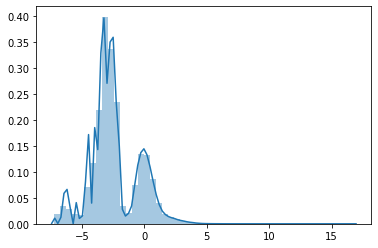

In [30]:
sns.distplot(X.flatten())

In [49]:
X.shape

(284, 240, 240, 3)